In [ ]:
!nvidia-smi

Tue May 30 21:28:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install pycocotools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip

--2023-05-30 21:28:07--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  70.9MB/s    in 0.7s    

2023-05-30 21:28:07 (70.9 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]



In [ ]:
!unzip PennFudanPed.zip

Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennFudanPed/Annotation/FudanPed00002.txt  
  inflating: PennFudanPed/Annotation/FudanPed00003.txt  
  inflating: PennFudanPed/Annotation/FudanPed00004.txt  
  inflating: PennFudanPed/Annotation/FudanPed00005.txt  
  inflating: PennFudanPed/Annotation/FudanPed00006.txt  
  inflating: PennFudanPed/Annotation/FudanPed00007.txt  
  inflating: PennFudanPed/Annotation/FudanPed00008.txt  
  inflating: PennFudanPed/Annotation/FudanPed00009.txt  
  inflating: PennFudanPed/Annotation/FudanPed00010.txt  
  inflating: PennFudanPed/Annotation/FudanPed00011.txt  
  inflating: PennFudanPed/Annotation/FudanPed00012.txt  
  inflating: PennFudanPed/Annotation/FudanPed00013.txt  
  inflating: PennFudanPed/Annotation/FudanPed00014.txt  
  inflating: PennFudanPed/Annotation/FudanPed00015.txt  
  i

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


In [ ]:
# mask = Image.open('PennFudanPed/PedMasks/FudanPed00003_mask.png')
# # each mask instance has a different color, from zero to N, where
# # N is the number of instances. In order to make visualization easier,
# # let's adda color palette to the mask.
# mask.putpalette([
#     0, 0, 0, # black background
#     255, 0, 0, # index 1 is red
#     255, 255, 0, # index 2 is yellow
#     255, 153, 0, # index 3 is orange
# ])
# mask
# # display(mask)

In [ ]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
dataset = PennFudanDataset('PennFudanPed/')
dataset[0]

(<PIL.Image.Image image mode=RGB size=559x536 at 0x7F1544C00A30>,
 {'boxes': tensor([[159., 181., 301., 430.],
          [419., 170., 534., 485.]]),
  'labels': tensor([1, 1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'image_id': tensor([0]),
  'area': tensor([35358., 36225.]),
  'iscrowd': tensor([0, 0])})

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 332277, done.
remote: Counting objects: 100% (48152/48152), done.
remote: Compressing objects: 100% (643/643), done.
remote: Total 332277 (delta 47660), reused 47861 (delta 47490), pack-reused 284125
Receiving objects: 100% (332277/332277), 670.26 MiB | 39.70 MiB/s, done.
Resolving deltas: 100% (305841/305841), done.
Note: switching to 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at be376084d8 version check against PyTorch's CUDA version


In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
import torchvision

In [ ]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:00<00:00, 196MB/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in

In [ ]:
output

{'loss_classifier': tensor(0.0932, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.0876, grad_fn=<DivBackward0>),
 'loss_mask': tensor(0.1702, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_objectness': tensor(0.0171, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0076, grad_fn=<DivBackward0>)}

In [ ]:
# For inference
model.eval()
predictions = model(images)

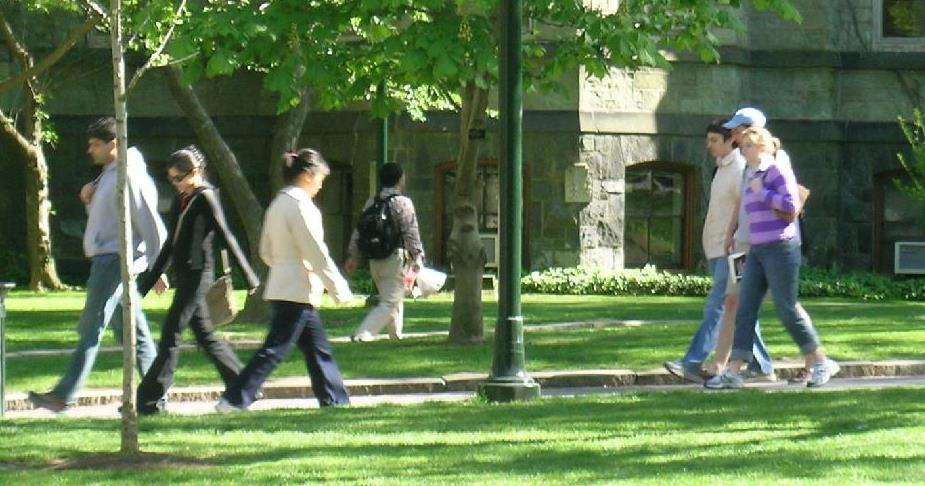

In [ ]:
Image.fromarray(images[0].mul(255).permute(1, 2, 0).byte().numpy())

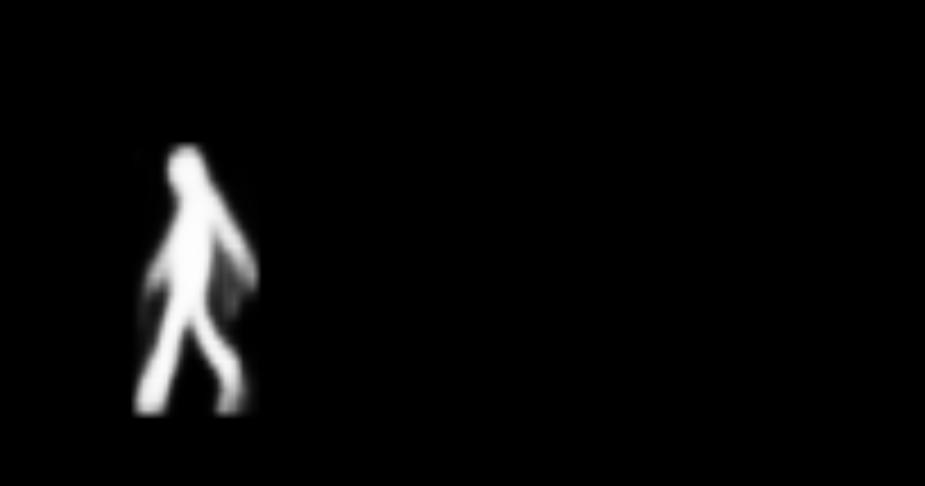

In [ ]:
Image.fromarray(predictions[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

In [ ]:
predictions[0]['masks'].shape

torch.Size([43, 1, 486, 925])

In [ ]:
coco_names = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [ ]:
with torch.no_grad():
  # forward pass of the image through the modle
  outputs = model(images)

outputs[0]

{'boxes': tensor([[133.0753, 146.2404, 259.3947, 413.7274],
         [226.8781, 144.0526, 353.8755, 415.2455],
         [341.6777, 160.3044, 423.4307, 346.8625],
         [725.5970, 120.8081, 836.8765, 391.7131],
         [ 25.9364, 112.4909, 165.5299, 415.8499],
         [679.0483, 118.7942, 751.4835, 386.1272],
         [360.6845, 194.4442, 402.9344, 260.2281],
         [403.7126, 259.7135, 421.8117, 298.1342],
         [205.7430, 246.8094, 237.9766, 326.7650],
         [444.5922, 208.8944, 485.4255, 341.1043],
         [713.7893, 107.5869, 774.2881, 369.6181],
         [723.2016, 104.5119, 771.2916, 167.3469],
         [129.4762, 157.0826, 171.7672, 384.5089],
         [166.1225, 145.2540, 210.8284, 211.1900],
         [ 98.0708, 140.3070, 160.4531, 389.3918],
         [208.8385, 243.7840, 241.7293, 327.5574],
         [140.9440, 200.3773, 202.2736, 290.4338],
         [755.1876, 133.7648, 817.6772, 312.0777],
         [152.7769, 202.6468, 190.6718, 281.5351],
         [414.5371, 26

In [ ]:
def get_outputs(image, model, threshold):
    with torch.no_grad():
        # forward pass of the image through the modle
        outputs = model([image])
    # get all the scores
    scores = list(outputs[0]['scores'].detach().cpu().numpy())
    # index of those scores which are above a certain threshold
    thresholded_preds_inidices = [scores.index(i) for i in scores if i > threshold]
    thresholded_preds_count = len(thresholded_preds_inidices)
    # get the masks
    masks = (outputs[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    # discard masks for objects which are below threshold
    masks = masks[:thresholded_preds_count]
    # get the bounding boxes, in (x1, y1), (x2, y2) format
    boxes = [[(int(i[0]), int(i[1])), (int(i[2]), int(i[3]))]  for i in outputs[0]['boxes'].detach().cpu()]
    # discard bounding boxes below threshold value
    boxes = boxes[:thresholded_preds_count]
    # get the classes labels
    labels = [coco_names[i] for i in outputs[0]['labels']]
    return masks, boxes, labels

In [ ]:
model.eval()
masks, boxes, labels = get_outputs(images[0], model, threshold=0.92)

In [ ]:
boxes

[[(133, 146), (259, 413)],
 [(226, 144), (353, 415)],
 [(341, 160), (423, 346)],
 [(725, 120), (836, 391)],
 [(25, 112), (165, 415)],
 [(679, 118), (751, 386)],
 [(360, 194), (402, 260)]]

In [ ]:
COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3))

In [ ]:
COLORS

array([[154.76929434,  74.19242292,  83.3312931 ],
       [ 74.47285065,  65.45222738, 250.82977321],
       [ 79.19544661,  80.01479018, 210.30068239],
       [110.24926324, 143.32351383, 127.28058423],
       [ 34.81817133,  89.76001544, 197.15335189],
       [222.96443716,  86.2581902 , 176.22372897],
       [195.82559985, 173.84965791, 198.21463251],
       [ 32.93076324,  58.25280456, 237.7820023 ],
       [172.13977109, 100.94051869, 204.76786472],
       [ 94.94260722, 184.50144756,  75.16898076],
       [178.0427967 ,  96.83215888,  42.99521013],
       [ 18.41861612,  61.27254646, 151.08744561],
       [162.52107617, 175.95500163, 232.85359687],
       [144.29833825, 109.63885349,  85.66412959],
       [161.78461906, 173.78482357, 146.85296308],
       [ 20.75198207, 131.66469271, 145.27432474],
       [243.04920964,  41.28319336, 214.64300886],
       [ 64.47824041, 234.68258907, 214.63541755],
       [201.3754805 ,   8.64277084, 112.79934582],
       [151.75120031,  19.15212

In [ ]:
import random
import cv2
from google.colab.patches import cv2_imshow

def draw_segmentation_map(image, masks, boxes, labels):
    alpha = 1
    beta = 0.6 # transparency for the segmentation map
    gamma = 0 # scalar added to each sum
    for i in range(len(masks)):
        red_map = np.zeros_like(masks[i]).astype(np.uint8)
        green_map = np.zeros_like(masks[i]).astype(np.uint8)
        blue_map = np.zeros_like(masks[i]).astype(np.uint8)
        # apply a randon color mask to each object
        color = COLORS[random.randrange(0, len(COLORS))]
        red_map[masks[i] == 1], green_map[masks[i] == 1], blue_map[masks[i] == 1]  = color
        # combine all the masks into a single image
        segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
        # convert from RGB to OpenCV BGR format
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        # apply mask on the image
        cv2.addWeighted(image, alpha, segmentation_map, beta, gamma, image)
        # draw the bounding boxes around the objects
        cv2.rectangle(image, boxes[i][0], boxes[i][1], color=color,
                      thickness=2)
        # put the label text above the objects
        cv2.putText(image , labels[i], (boxes[i][0][0], boxes[i][0][1]-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, color,
                    thickness=2, lineType=cv2.LINE_AA)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image

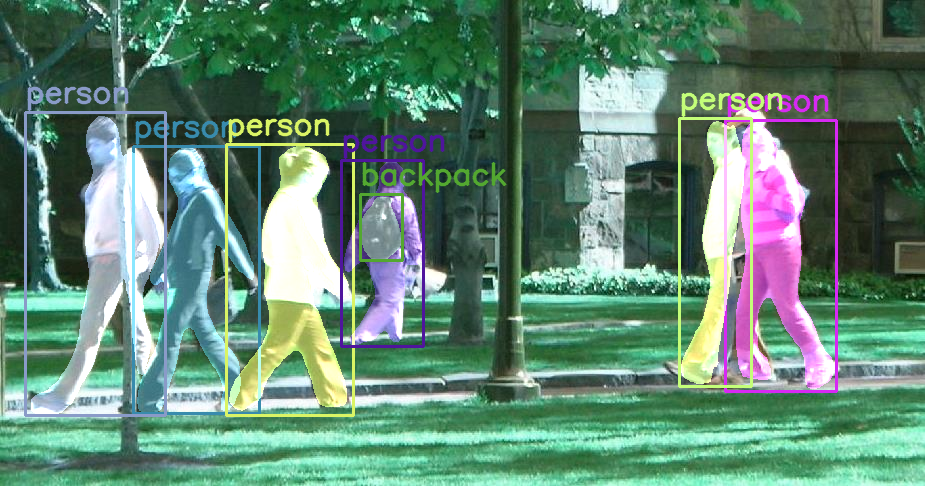

In [ ]:
result = draw_segmentation_map(images[0].mul(255).permute(1, 2, 0).byte().numpy(), masks, boxes, labels)

# visualize the image
cv2_imshow(result)

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True, num_classes=2)
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# now get the number of input features for the mask classifier
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 128
# and replace the mask predictor with a new one
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                    hidden_layer,
                                                    num_classes)

In [ ]:
model

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [ ]:
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()


Epoch: [0]  [ 0/60]  eta: 0:08:16  lr: 0.000090  loss: 2.5159 (2.5159)  loss_classifier: 0.5626 (0.5626)  loss_box_reg: 0.5477 (0.5477)  loss_mask: 1.3791 (1.3791)  loss_objectness: 0.0133 (0.0133)  loss_rpn_box_reg: 0.0133 (0.0133)  time: 8.2708  data: 0.4200  max mem: 2425
Epoch: [0]  [10/60]  eta: 0:01:01  lr: 0.000936  loss: 1.5950 (1.5733)  loss_classifier: 0.4376 (0.3869)  loss_box_reg: 0.3514 (0.3524)  loss_mask: 0.7270 (0.8045)  loss_objectness: 0.0286 (0.0244)  loss_rpn_box_reg: 0.0043 (0.0051)  time: 1.2212  data: 0.0437  max mem: 2539
Epoch: [0]  [20/60]  eta: 0:00:35  lr: 0.001783  loss: 0.8384 (1.0845)  loss_classifier: 0.1918 (0.2600)  loss_box_reg: 0.2328 (0.2750)  loss_mask: 0.2698 (0.5241)  loss_objectness: 0.0175 (0.0210)  loss_rpn_box_reg: 0.0030 (0.0044)  time: 0.5173  data: 0.0076  max mem: 3061
Epoch: [0]  [30/60]  eta: 0:00:23  lr: 0.002629  loss: 0.5043 (0.8981)  loss_classifier: 0.0851 (0.1986)  loss_box_reg: 0.1886 (0.2582)  loss_mask: 0.1987 (0.4195)  loss_ob

In [ ]:
model.eval()
masks, boxes, labels = get_outputs(images[1].cuda(), model, threshold=0.8)

In [ ]:
torch.save(model.state_dict(),'maskmodel')

In [ ]:
result = draw_segmentation_map(images[0].mul(255).permute(1, 2, 0).byte().numpy(), masks, boxes, labels)

# visualize the image
cv2_imshow(result)

AxisError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
